# Regression Project: EDA → Preprocessing → Train/Test → Model → Save/Load

## Что получится в конце
1) вы загрузите датасет  
2) определите `TARGET_COL`  
3) построите пайплайн предобработки  
4) обучите несколько моделей, сравните по CV  
5) выберете лучшую, протестируете на test  
6) сохраните модель на диск и загрузите обратно  
7) сделаете предсказание на новых данных (или test)

> Совет: в Kaggle часто есть столбцы вроде `Id` или утечки. Мы покажем, как это проверять.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

import joblib

sns.set_context("notebook")
np.random.seed(42)

print("Ready!")

Ready!


# 1) Загрузка датасета

## Ваш Kaggle CSV
1) Скачайте `train.csv` (или любой csv)  
2) Положите рядом с ноутбуком (или укажите путь)

Далее **обязательно** выставьте `TARGET_COL` под ваш датасет.


In [ ]:
# === ВАЖНО: поменяйте под ваш файл ===
DATA_PATH = "_____.csv"   # например: "house_prices_train.csv"
TARGET_COL = '_____'         # например: "SalePrice"

# Пытаемся загрузить ваш csv, иначе — демо California Housing
df = None

try:
    df = pd.read_csv(_____)
    print("Loaded:", DATA_PATH, "| shape:", df._____)
except Exception as e:
    print("Could not read CSV:", e)
    print("Falling back to California Housing demo dataset...")

if df is None:
    from sklearn.datasets import fetch_california_housing
    data = fetch_california_housing(as_frame=True)
    df = data.frame.copy()
    df.rename(columns={"MedHouseVal": "target"}, inplace=True)
    TARGET_COL = "target"
    print("Loaded California Housing | shape:", df.shape)

df.head()

Loaded: train.csv | shape: (300, 2)


,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


# 2) Быстрый обзор данных (5 минут)

Зачем:
- увидеть размер, типы столбцов
- понять, где `target`
- заметить явные мусорные столбцы (Id, текстовые комментарии и т.п.)


In [ ]:
print("Shape:", df._____)
df._____(3)

Shape: (300, 2)


,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262


In [ ]:
print("Dtypes count:")
print(df.dtypes._____())

print("\nFirst 15 columns and dtypes:")
print(df.dtypes._____(15))

if _____ is None:
    print("\n⚠️ TARGET_COL = None. Поставьте целевую колонку (например, 'SalePrice').")
else:
    print("\nTARGET_COL =", _____)

Dtypes count:
int64      1
float64    1
Name: count, dtype: int64

First 15 columns and dtypes:
x      int64
y    float64
dtype: object

TARGET_COL = y


# 3) Мини-EDA (matplotlib + seaborn)

Мы делаем минимум, чтобы:
- понять распределение `target` (есть ли сильные выбросы)
- оценить пропуски
- увидеть “какие числовые признаки связаны с target” (корреляции)
- посмотреть 2–3 scatter графика (отношение признака к target)


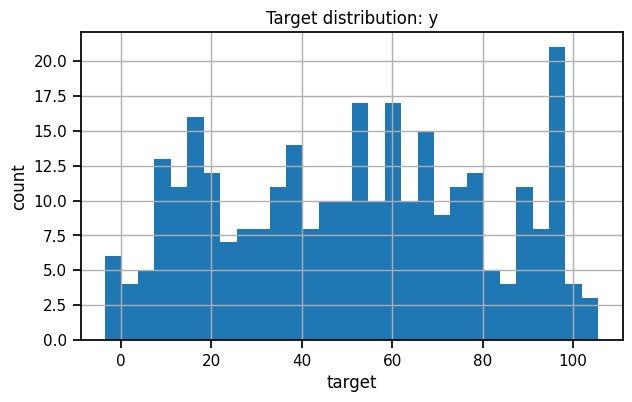

No missing values detected (or none in top).


,corr,abs_corr
x,0.994545,0.994545


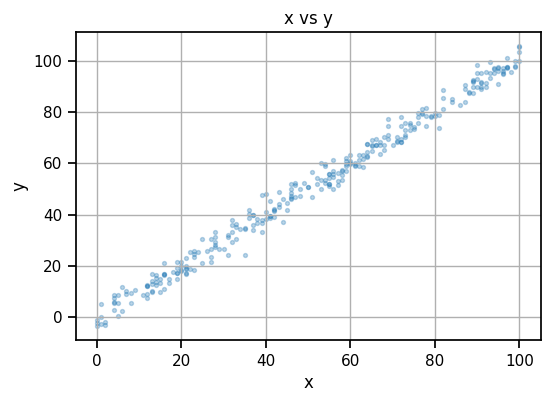

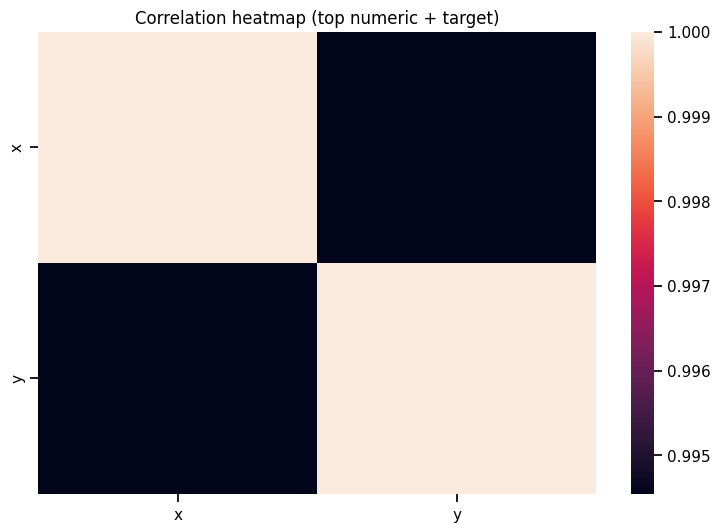

In [ ]:
assert TARGET_COL in df.columns, "Поставьте TARGET_COL так, чтобы он существовал в df.columns"

# 3.1) target distribution
plt.figure(_____=(7,4))
plt.hist(df[TARGET_COL].dropna(), bins=30)
plt.title(f"Target distribution: {_____}")
plt.xlabel("target")
plt.ylabel("count")
plt.grid(True)
plt.show()

# 3.2) missing values (top 15)
na_share = df.isna().mean().sort_values(ascending=False)
na_top = na_share[na_share > 0].head(15)

if len(na_top) > 0:
    plt.figure(_____=(8,4))
    plt.bar(na_top.index.astype(str), na_top.values)
    plt.title("Missing values share (top)")
    plt.ylabel("share")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.show()
else:
    print("No missing values detected (or none in top).")

# 3.3) numeric correlations with target (top 10 by abs corr)
num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols = [c for c in num_cols if c != TARGET_COL]

if len(num_cols) > 0:
    corr = df[num_cols + [_____]].corr(numeric_only=True)[TARGET_COL].drop(TARGET_COL)
    top = corr.abs().sort_values(ascending=False).head(10)

    corr_table = pd.DataFrame({"corr": corr.loc[top.index], "abs_corr": top.values}).sort_values("abs_corr", ascending=False)
    display(corr_table)

    # 3.4) scatter for top 3 numeric features
    top3 = top.index[:3].tolist()
    for col in top3:
        plt._____(figsize=(6,4))
        plt.scatter(df[col], df[TARGET_COL], s=8, alpha=0.3)
        plt.title(f"{col} vs {TARGET_COL}")
        plt._____(col)
        plt._____(TARGET_COL)
        plt.grid(True)
        plt.show()

    # 3.5) heatmap for top 10 features + target
    cols_hm = top.index.tolist() + [TARGET_COL]
    plt.figure(figsize=(9,6))
    sns._____(df[cols_hm].corr(numeric_only=True), annot=False)
    plt.title("Correlation heatmap (top numeric + target)")
    plt.show()
else:
    print("No numeric columns found (besides target).")

# 4) Разделение на X/y + train/test split

Зачем:
- `X` — признаки (всё, кроме target)
- `y` — целевая переменная
- test набор нужен для честной проверки

⚠️ Важно: **не делаем fit-преобразования на test** (это data leakage).


In [ ]:
X = df.drop(columns=[TARGET_COL])
y = df[_____]

# Можно исключить очевидные id-колонки (если они есть):
# if "Id" in X.columns: X = X.drop(columns=["Id"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=_____, random_state=_____
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (225, 1) Test: (75, 1)


# 5) Preprocessing через Pipeline + ColumnTransformer

Идея:
- числовые: `median imputer` + `StandardScaler`
- категориальные: `most_frequent imputer` + `OneHotEncoder`

Такой пайплайн универсален для Kaggle-таблиц и защищает от утечек.


In [ ]:
_____ = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
_____ = [c for c in X_train.columns if c not in cat_features]

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))
print("Example cat:", cat_features[:5])

numeric_pipe = Pipeline([
    ("imputer", _____(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", One_____(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", cat_pipe, cat_features),
])


Numeric features: 1
Categorical features: 0
Example cat: []


## Метрики для регрессии

- MAE: средняя абсолютная ошибка  
- RMSE: “квадратичная” ошибка (штрафует большие промахи)  
- R2: качество “насколько лучше среднего”  


In [ ]:
def report_regression(y_true, y_pred, name=""):
    _____ = mean_absolute_error(y_true, y_pred)
    _____ = np.sqrt(mean_squared_error(y_true, y_pred))
    _____ = r2_score(y_true, y_pred)
    print(name)
    print("  MAE :", mae)
    print("  RMSE:", rmse)
    print("  R2  :", r2)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# 6) Baseline: LinearRegression

Быстрый старт, чтобы увидеть “планку” качества.


LinearRegression (test)
  MAE : 2.572735589268418
  RMSE: 3.111650795331026
  R2  : 0.9901699118343359


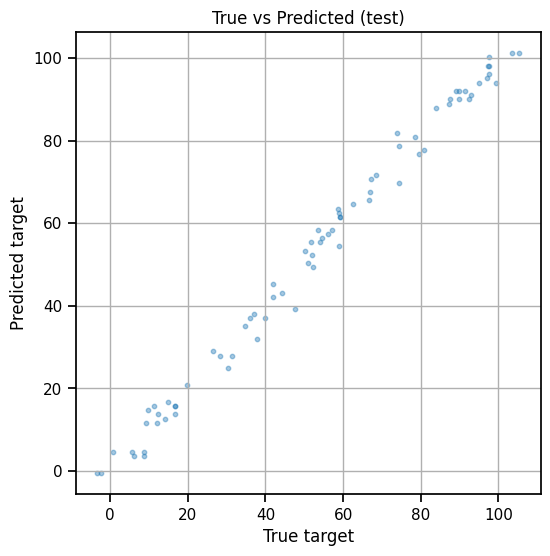

In [ ]:
baseline_lr = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

baseline_lr.fit(X_train, y_train)
pred_test = baseline_lr.predict(X_test)

_ = report_regression(y_test, pred_test, "LinearRegression (test)")

plt.figure(figsize=(6,6))
plt._____(y_test, pred_test, s=10, alpha=0.4)
plt.title("True vs Predicted (test)")
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.grid(True)
plt.show()

# 7) Сравнение моделей по CV (KFold=5)

Мы сравним:
- LinearRegression
- Ridge / Lasso
- RandomForest
- Boosting (XGBoost, если установлен; иначе HistGradientBoostingRegressor)

Оценка: средний CV R2 на **train**.


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LR": Pipeline([("preprocess", preprocess), ("model", LinearRegression())]),
    "Ridge(alpha=1)": Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=1.0))]),
    "Lasso(alpha=0.001)": Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=0.001, max_iter=20000))]),
    "RF": Pipeline([("preprocess", preprocess), ("model", RandomForestRegressor(
        n_estimators=300, min_samples_leaf=5, random_state=42, n_jobs=-1
    ))]),
}

xgb_available = True
try:
    from xgboost import XGBRegressor
except Exception:
    xgb_available = False

if xgb_available:
    models["XGB"] = Pipeline([("preprocess", preprocess), ("model", XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9,
        random_state=42, n_jobs=-1
    ))])
else:
    from sklearn.ensemble import HistGradientBoostingRegressor
    models["HGB"] = Pipeline([("preprocess", preprocess), ("model", HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, random_state=42
    ))])

cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, _____, _____, cv=cv, scoring="r2")
    cv_results.append({"model": name, "cv_r2_mean": scores.mean(), "cv_r2_std": scores.std()})
    print(f"{name:12s} | mean={scores.mean():.4f} std={scores.std():.4f} | scores={np.round(scores, 4)}")

cv_table = pd.DataFrame(cv_results).sort_values("cv_r2_mean", ascending=False)
cv_table

LR           | mean=0.9882 std=0.0021 | scores=[0.9886 0.9904 0.9871 0.9847 0.9899]
Ridge(alpha=1) | mean=0.9881 std=0.0021 | scores=[0.9887 0.9906 0.9869 0.9848 0.9896]
Lasso(alpha=0.001) | mean=0.9882 std=0.0021 | scores=[0.9886 0.9904 0.9871 0.9847 0.9899]
RF           | mean=0.9842 std=0.0024 | scores=[0.9835 0.9882 0.9823 0.9817 0.9855]
XGB          | mean=0.9822 std=0.0033 | scores=[0.9814 0.9866 0.9775 0.9805 0.9852]


,model,cv_r2_mean,cv_r2_std
2,Lasso(alpha=0.001),0.988154,0.002073
0,LR,0.988154,0.002073
1,Ridge(alpha=1),0.988124,0.002068
3,RF,0.984240,0.002361
4,XGB,0.982239,0.003280


# 8) Мини-GridSearchCV

Мы настроим:
- Ridge: `alpha`
- RandomForest: `n_estimators`, `min_samples_leaf`

> Если у вас слабый ноутбук — можно уменьшить сетки.


In [ ]:
cv = KFold(n_splits=_____, shuffle=_____, random_state=42)

# Ridge grid
ridge_pipe = Pipeline([("preprocess", _____), ("model", Ridge())])
ridge_grid = {"model__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]}
gs_ridge = GridSearchCV(ridge_pipe, ridge_grid, cv=cv, scoring="r2")
gs_ridge.fit(X_train, y_train)
print("Best Ridge:", gs_ridge.best_params_, "CV R2:", gs_ridge.best_score_)

# RF grid
rf_pipe = Pipeline([("preprocess", _____), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
rf_grid = {"model__n_estimators": [200, 500], "model__min_samples_leaf": [1, 5, 10]}
gs_rf = GridSearchCV(rf_pipe, rf_grid, cv=cv, scoring="r2")
gs_rf.fit(X_train, y_train)
print("Best RF:", gs_rf.best_params_, "CV R2:", gs_rf.best_score_)

Best Ridge: {'model__alpha': 0.1} CV R2: 0.9881534655171944
Best RF: {'model__min_samples_leaf': 5, 'model__n_estimators': 500} CV R2: 0.984326270688437


# 9) Финальная модель → test

Честная схема:
- всё подбираем на train (CV, grid)
- один раз меряем test


Selected: Ridge(GridSearch)
Ridge(GridSearch) (test)
  MAE : 2.571061450231649
  RMSE: 3.110583139922891
  R2  : 0.9901766563869604


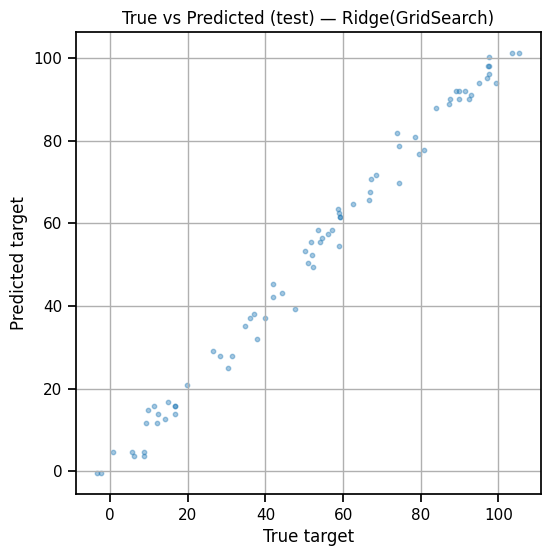

In [ ]:
best_model = gs_ridge.best_estimator_
best_name = "Ridge(GridSearch)"
if gs_rf.best_score_ > gs_ridge.best_score_:
    best_model = gs_rf.best_estimator_
    best_name = "RF(_____)"

print("Selected:", best_name)

best_model.fit(X_train, y_train)
pred_test = best_model.predict(X_test)
_ = report_regression(y_test, pred_test, f"{best_name} (test)")

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test, s=10, alpha=0.4)
plt._____(f"True vs Predicted (test) — {best_name}")
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.grid(True)
plt.show()

# 10) Посмотреть параметры и важность/коэффициенты

- `get_params()` — все параметры пайплайна
- `coef_` у линейных моделей
- `feature_importances_` у леса

После one-hot получаем много признаков → достаём их из `preprocess.get_feature_names_out()`.


In [ ]:
print("Best model params (some):")
params = best_model.get_params()
for k in sorted([k for k in params.keys() if "model__" in k])[:40]:
    print(k, "=", params[k])

try:
    pre = best_model.named_steps["preprocess"]
    feature_names = pre.get_feature_names_out()
    core = best_model.named_steps["model"]

    if hasattr(core, "coef_"):
        coefs = pd.Series(core.coef_, index=feature_names).sort_values(key=np.abs, ascending=False)
        print("\nTop 15 abs coefficients:")
        display(coefs.head(15))
    elif hasattr(core, "feature_importances_"):
        imp = pd.Series(core.feature_importances_, index=feature_names).sort_values(ascending=False)
        print("\nTop 15 importances:")
        display(imp.head(15))
    else:
        print("Model has no coef_ or feature_importances_.")
except Exception as e:
    print("Could not extract feature names / importance:", e)

Best model params (some):
model__alpha = 0.1
model__copy_X = True
model__fit_intercept = True
model__max_iter = None
model__positive = False
model__random_state = None
model__solver = auto
model__tol = 0.0001

Top 15 abs coefficients:


,0
num__x,27.995064


# 11) Сохранение и загрузка модели (joblib)

Это последний шаг проекта: модель готова к использованию.


In [ ]:
MODEL_PATH = "regression_model.joblib"

joblib._____(best_model, MODEL_PATH)
print("Saved model to:", MODEL_PATH)

loaded_model = joblib._____(MODEL_PATH)
print("Loaded model type:", type(loaded_model))

# Быстрый тест на первых 5 строках test
pred_a = best_model.predict(X_test.head(5))
pred_b = loaded_model.predict(X_test.head(5))

print("Pred original:", np.round(pred_a, 4))
print("Pred loaded  :", np.round(pred_b, 4))

Saved model to: regression_model.joblib
Loaded model type: <class 'sklearn.pipeline.Pipeline'>
Pred original: [90.9562 76.7298 95.021   4.5811 91.9724]
Pred loaded  : [90.9562 76.7298 95.021   4.5811 91.9724]


# 12) Чек-лист под Kaggle

1) `DATA_PATH`, `TARGET_COL`  
2) `df.head()` + `df.dtypes` + `df.isna().mean()`  
3) EDA: target hist + top missing + corr/scatter  
4) train/test split  
5) preprocess (num/cat)  
6) baseline LR  
7) CV сравнение  
8) GridSearch  
9) финальный тест на test  
10) `joblib.dump` и проверка `joblib.load`